In [68]:
import glob

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs

from unseen import fileio

In [24]:
all_dry_years = np.array([1901, 1902, 1922, 1937, 1940, 1944, 1948, 1957, 1972, 1980, 1994, 2002, 2009, 2018, 2019])
all_wet_years = np.array([1917, 1920, 1921, 1931, 1955, 1958, 1963, 1971, 1973, 1974, 1975, 1978, 1988, 1999, 2011, 2016])

In [ ]:
def detrend(da, dim)
    """Linearly detrend along given dimension"""
    
    p = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], p['polynomial_coefficients'])
    
    return da - fit

TODO: Edit the detrending function so it returns adjusted data instead of anomaly (e.g. like https://github.com/DamienIrving/ocean-analysis/blob/master/data_processing/remove_drift.py#L58).

In [109]:
def plot_data(da, levels, cmap='viridis_r'):
    """Plot the data"""
    
    fig = plt.figure(figsize=[12,5])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    da.plot.contourf(ax=ax,
                     levels=levels,
                     extend='both',
                     transform=ccrs.PlateCarree(),
                     cmap=cmap)
    ax.coastlines()
    plt.show()

## SST

SST composites for Jan-Mar (ENSO) and Aug-Dec (IOD).

In [3]:
sst_file = '/g/data/ua8/HadISST/v1-1/HadISST_sst.nc'

In [4]:
sst_ds = fileio.open_dataset(sst_file, metadata_file='/home/599/dbi599/unseen/config/dataset_hadisst.yml')

In [5]:
sst_ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nv: 2, time: 1809)
Coordinates:
  * time       (time) object 1870-01-16 11:59:59.505615 ... 2020-09-16 12:00:00
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 dask.array<chunksize=(1809, 2), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(1809, 180, 360), meta=np.ndarray>
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    2/11/2020 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [45]:
def is_jfm(month):
    """Is Jan-Mar season"""
    return month <= 3

def is_asond(month):
    "Is Aug-Dec season"
    return month >= 8

In [48]:
sst_JFM = sst_ds['sst'].sel({'time': is_jfm(sst_ds['time.month'])}).groupby('time.year').mean('time', keep_attrs=True)
sst_ASOND = sst_ds['sst'].sel({'time': is_asond(sst_ds['time.month'])}).groupby('time.year').mean('time', keep_attrs=True)

In [49]:
sst_JFM

<xarray.DataArray 'sst' (year: 151, lat: 180, lon: 360)>
dask.array<stack, shape=(151, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * year     (year) int64 1870 1871 1872 1873 1874 ... 2016 2017 2018 2019 2020
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

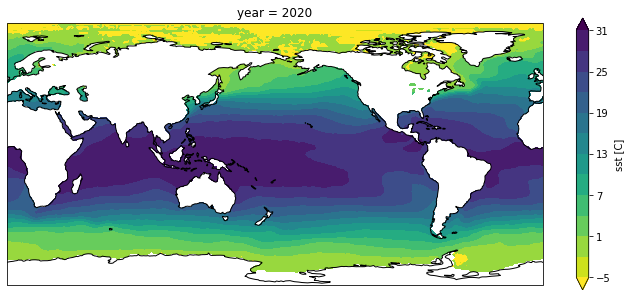

In [75]:
plot_data(sst_JFM.isel(year=-1), np.arange(-5, 32, 3))

In [77]:
p = sst_JFM.polyfit(dim='year', deg=1)
p

<xarray.Dataset>
Dimensions:               (degree: 2, lat: 180, lon: 360)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 dask.array<chunksize=(2, 180, 360), meta=np.ndarray>

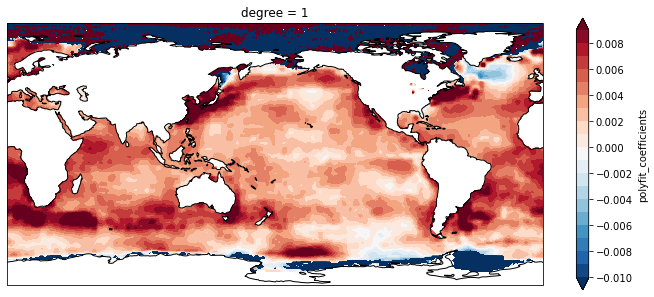

In [111]:
plot_data(p['polyfit_coefficients'].sel({'degree': 1}), np.arange(-.01, .01, .001), cmap='RdBu_r')

In [80]:
fit = xr.polyval(sst_JFM['year'], p['polyfit_coefficients'])
fit

<xarray.DataArray (year: 151, lat: 180, lon: 360)>
dask.array<sum-aggregate, shape=(151, 180, 360), dtype=float64, chunksize=(151, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1870 1871 1872 1873 1874 ... 2016 2017 2018 2019 2020
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [115]:
detrended = sst_JFM - fit

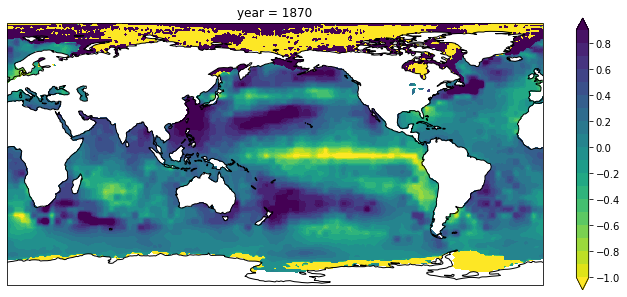

In [119]:
plot_data(detrended.isel(year=0), np.arange(-1, 1, 0.1))

In [56]:
sst_JFM_clim = sst_JFM.sel({'year': slice(1971, 2000)}).mean('year', keep_attrs=True)
sst_ASOND_clim = sst_ASOND.sel({'year': slice(1971, 2000)}).mean('year', keep_attrs=True)

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


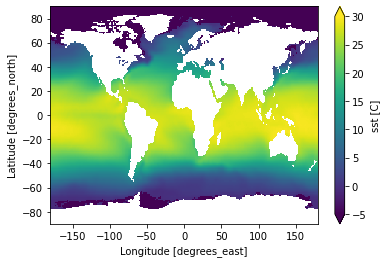

In [55]:
sst_JFM_clim.plot(vmin=-5, vmax=30)

In [57]:
sst_JFM_anom = sst_JFM - sst_JFM_clim

In [58]:
sst_JFM_anom

<xarray.DataArray 'sst' (year: 151, lat: 180, lon: 360)>
dask.array<sub, shape=(151, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * year     (year) int64 1870 1871 1872 1873 1874 ... 2016 2017 2018 2019 2020

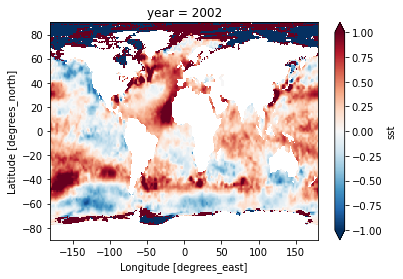

In [63]:
sst_JFM_anom.sel(year=2002).plot(vmin=-1, vmax=1, cmap='RdBu_r')

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


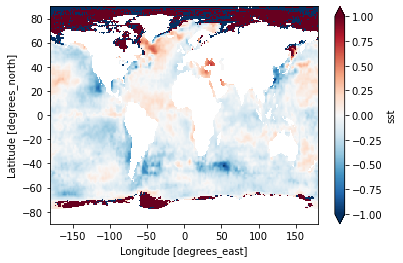

In [67]:
sst_JFM_anom.sel(year=all_wet_years).mean('year').plot(vmin=-1, vmax=1, cmap='RdBu_r')

## Z500

Z500 anomaly composites for MAM, JJA, SON (to indicate what the SAM is doing).

In [6]:
era5_files = glob.glob('/g/data/rt52/era5/pressure-levels/monthly-averaged/z/*/z_era5_moda_pl_*.nc')
era5_files.sort()
era5_files

[]

In [10]:
era5_ds = fileio.open_dataset(era5_files[0], metadata_file='/home/599/dbi599/unseen/config/dataset_era5_monthly.yml')

TODO: Write a open_mfdataset function that handles netcdf

In [11]:
era5_ds

<xarray.Dataset>
Dimensions:  (lat: 721, level: 37, lon: 1440, time: 1)
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * level    (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time     (time) object 1979-01-01 00:00:00
Data variables:
    z        (time, level, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 pressure-levels monthly-averaged geopotential 19790101...
    history:      2020-11-06 10:07:56 UTC+1100 by era5_replication_tools-1.5....